# Курбанова Комила, БПМИ218

# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 09.11.2023

Мягкий дедлайн: 22.11.2023

Жесткий дедлайн: 26.11.2023

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**: 11.5 ну от силы

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного жёсткого дедлайна нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [ ]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: Это вероятности принадлежности классу 1 (потому что смотрим [:,1])

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [ ]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000


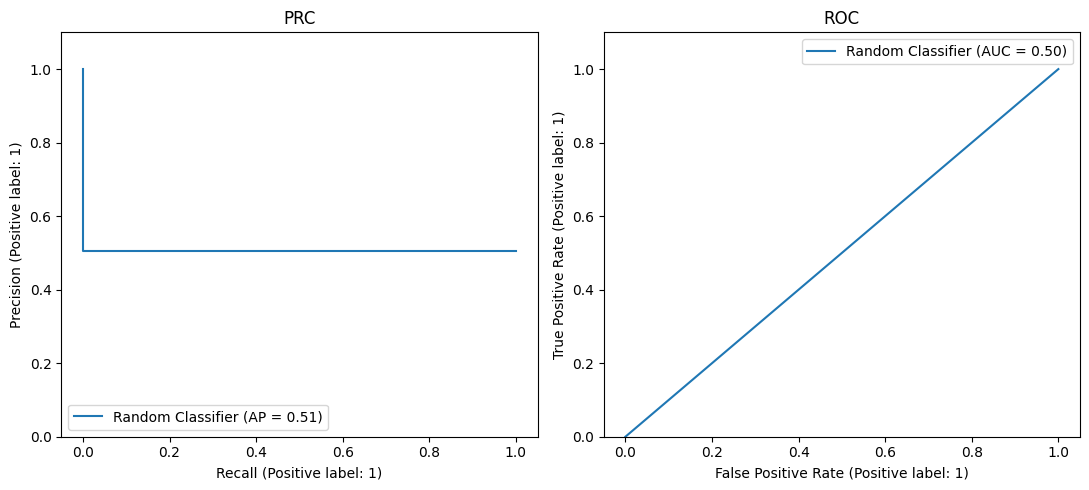

In [ ]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
  if ax is None:
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))

  print(classifier_name, 'metrics')
  PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
  precision, recall, _ = precision_recall_curve(y_true, y_pred)
  print('AUC-PR: %.5f' % auc(recall, precision))
  ax[0].set_title("PRC")
  ax[0].set_ylim(0, 1.1)

  RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
  print('AUC-ROC: %.5f' % roc_auc_score(y_true, y_pred))
  ax[1].set_title("ROC")
  ax[1].set_ylim(0, 1.1)

  plt.tight_layout()
  plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [ ]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])
precision, recall, _ = precision_recall_curve(y_test, y_random)
  # добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_random),
      0
]

  # по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`).

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [ ]:
param_grid = {'C': np.logspace(-5, 2, 8)}

SVC_best = GridSearchCV(SVC(kernel='linear'), param_grid=param_grid, scoring=make_scorer(average_precision_score), n_jobs=-1, cv=5)
SVC_best.fit(X_train, y_train)
best_params = SVC_best.best_params_
print('Best C = ', best_params['C'])
print('Best score = ', SVC_best.best_score_)

Best C =  0.1
Best score =  0.7153903901388169


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

SVM Classifier metrics
AUC-PR: 0.81492
AUC-ROC: 0.84792


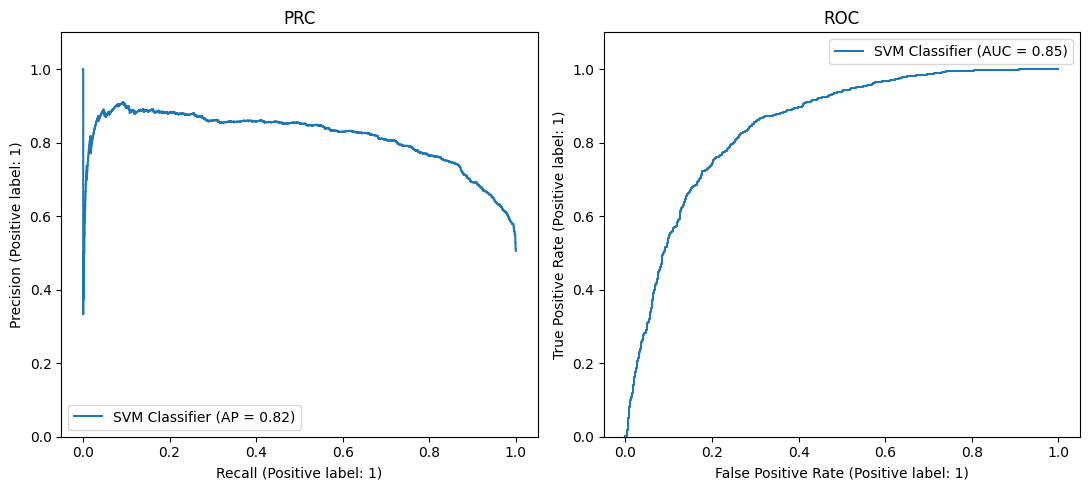

In [ ]:
y_svm = SVC_best.decision_function(X_test)
depict_pr_roc(y_test, y_svm, 'SVM Classifier')

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_svm)
df_metrics.loc['SVM Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_svm),
      best_params['C']
]
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.500000,0.0
SVM Classifier,0.814916,0.847915,0.1


Очень большая разница, видно, что SVM справляется намного лучше

__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
param_grid = {'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]}

LogReg_best = GridSearchCV(LogisticRegression(penalty='l2', random_state=42), param_grid=param_grid, scoring=make_scorer(average_precision_score), n_jobs=-1, cv=5)
LogReg_best.fit(X_train, y_train)
lr_best_params = LogReg_best.best_params_
print('Best C = ', lr_best_params['C'])
print('Best score = ', LogReg_best.best_score_)

Best C =  0.01
Best score =  0.7162114725281367


Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

In [ ]:
from sklearn.metrics import roc_curve


def depict_pr_roc_multi(classifiers, y_true, y_preds, ax=None, show_legend=True):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    for classifier_name, y_pred in zip(classifiers, y_preds):
        print(classifier_name, 'metrics')
        precision, recall, _ = precision_recall_curve(y_true, y_pred)
        ax[0].step(recall, precision, where='post', label=f'{classifier_name} (AUC-PR={auc(recall, precision):.5f})')
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        ax[1].plot(fpr, tpr, label=f'{classifier_name} (AUC-ROC={roc_auc_score(y_true, y_pred):.5f})')

    ax[0].set_title("PRC")
    ax[0].set_ylim(0, 1.1)
    ax[0].legend()

    ax[1].set_title("ROC")
    ax[1].set_ylim(0, 1.1)
    ax[1].legend()

    plt.tight_layout()

In [ ]:
y_logreg = LogReg_best.decision_function(X_test)

Random metrics
SVM metrics
Logistic Regression metrics


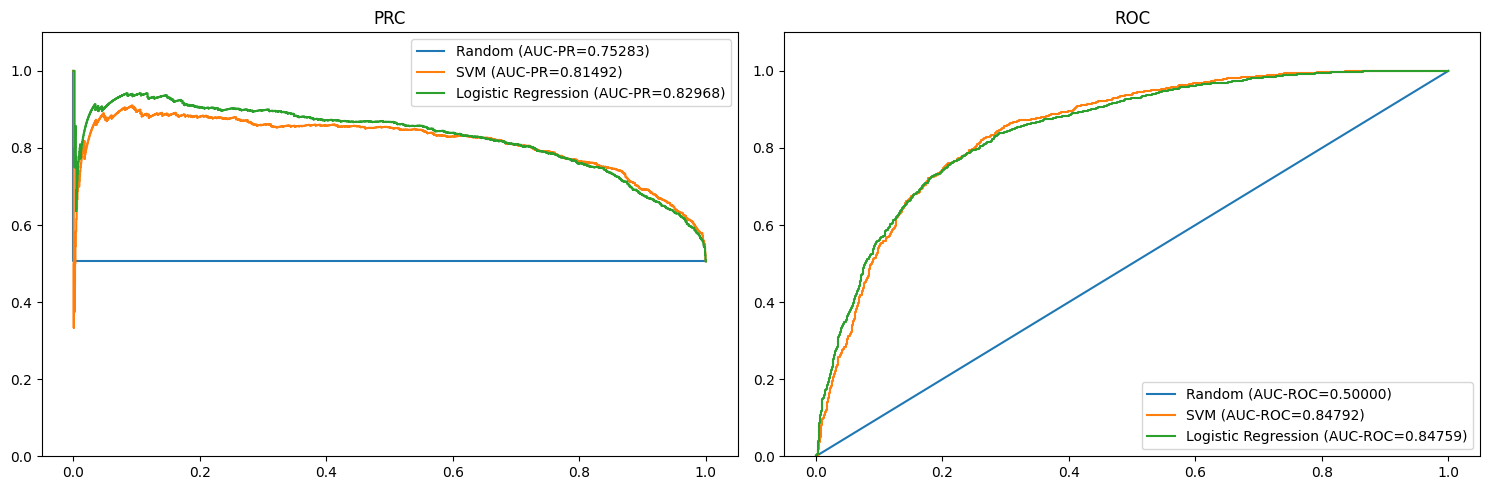

In [ ]:
classifiers = ['Random', 'SVM', 'Logistic Regression']
y_preds_multi = [y_random, y_svm, y_logreg]
depict_pr_roc_multi(classifiers, y_test, y_preds_multi, show_legend=True)

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_logreg)
df_metrics.loc['Logistic Regression Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_logreg),
      lr_best_params['C']
]
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.500000,0.00
SVM Classifier,0.814916,0.847915,0.10
Logistic Regression Classifier,0.829676,0.847587,0.01


**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** В целом между ниси разницы мало ощутима (на графике даже видно, что кривые очень близки). Но для логистической регресси показатель AUC_PR на 0.015 больше, что немного лучше

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`).

In [ ]:
X, y = make_classification(
    n_samples=1000, n_features=2, n_informative=2, n_redundant=0, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = SVC(kernel='linear').fit(X_train, y_train)

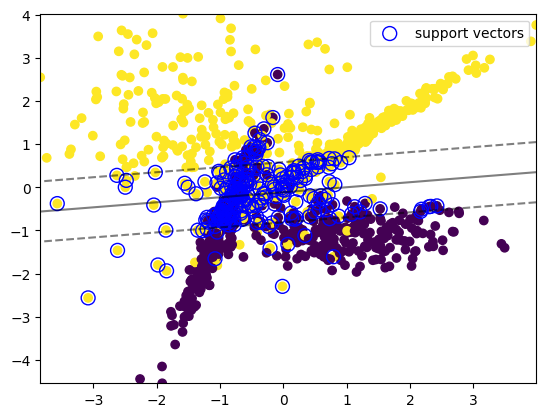

In [ ]:
def plot_svm_2D(X, y, model,  plot_support=True):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape(YY.shape)

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])


    #Отрисовали выборку
    plt.scatter(x=X[:, 0], y=X[:, 1], c=y)

    #Отрисовали опорные векторы
    if plot_support:
        plt.scatter(x=model.support_vectors_[:, 0], y=model.support_vectors_[:, 1],
                   label='support vectors',
                   s=100,
                   linewidth=1,
                   edgecolor="blue",
                   facecolors='none')

    plt.legend()

plot_svm_2D(X, y, model)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** Это те объекты, которые попали в неверную полуплоскость относительно своей линии отступа (я не знаю, как ее назвать, штрихованный единичный отступ от рязделяющей прямой)

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [ ]:
model = LogisticRegression().fit(X_train, y_train)

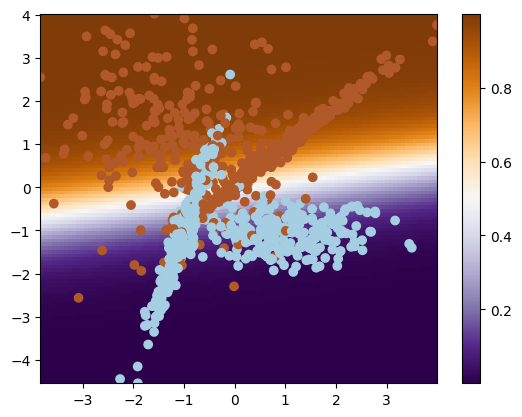

In [ ]:
def plot_logreg_2D(X, y, model):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(xy)[:, 1]
    Z = Z.reshape((xx.shape[0], -1)).T


    image = plt.imshow(Z, interpolation='nearest',
                       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)

    #Отрисовали выборку
    plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.Paired)

    plt.colorbar(image)


plot_logreg_2D(X, y, model)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** По тепловой карте видим, что там, где значение 0.5 (в белой области), модель не уверена, относится ли объект к положительному классу. Эта область очень близка к тому, что мы рисовали на прошлом графике. Чем ближе мы находимся к разделяющей прямой, тем больше модель тем меньше модель понимает, к какому классу принадлежит объект

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [ ]:
def plot_calibration_curve(ax, y_test, preds, label):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    plt.figure(figsize=(6,6))
    ax.plot(bin_middle_points, bin_real_ratios, label=label)

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [ ]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
model_logreg = LogisticRegression(penalty='l2', random_state=42, C=lr_best_params['C']).fit(X_train, y_train)
y_logreg = model_logreg.predict_proba(X_test)[:,1]

model_svm = SVC(kernel='linear', C=best_params['C']).fit(X_train, y_train)
y_svm = model_svm.decision_function(X_test)
y_svm = (y_svm - y_svm.min()) / (y_svm.max() - y_svm.min())

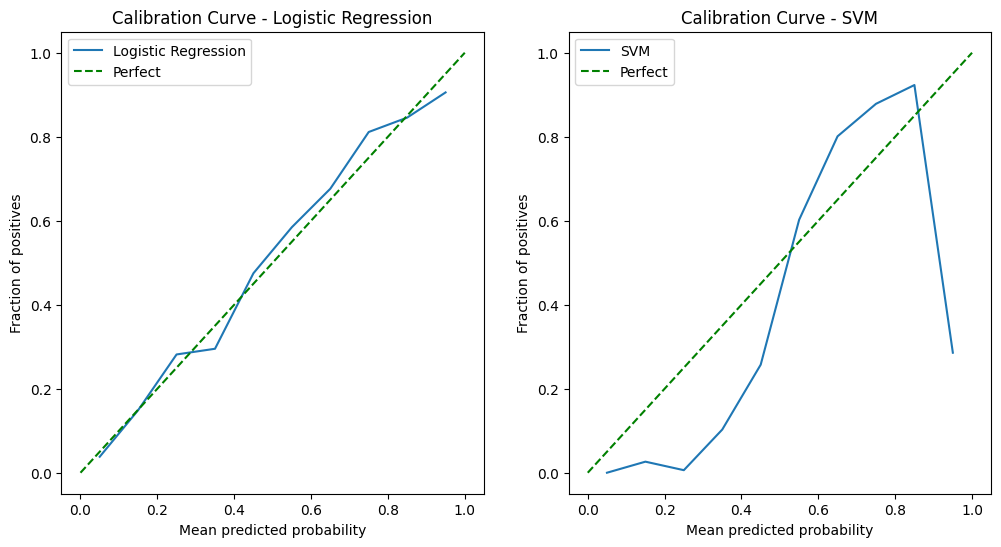

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

plot_calibration_curve(axs[0], y_test, y_logreg, 'Logistic Regression')
axs[0].plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')
axs[0].set_xlabel('Mean predicted probability')
axs[0].set_ylabel('Fraction of positives')
axs[0].set_title('Calibration Curve - Logistic Regression')
axs[0].legend()

plot_calibration_curve(axs[1], y_test, y_svm, 'SVM')
axs[1].plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')
axs[1].set_xlabel('Mean predicted probability')
axs[1].set_ylabel('Fraction of positives')
axs[1].set_title('Calibration Curve - SVM')
axs[1].legend()

plt.tight_layout()
plt.show()

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии?

**Ответ:** SVM просто "туши свет, бросай гранату", очень плохо, так еще и в конце странное поведение (потому что под вероятности он не заточен). У LR все хорошо, потому что мы изначально строили так, чтобы приближать вероятности с помощью сигмоиды

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

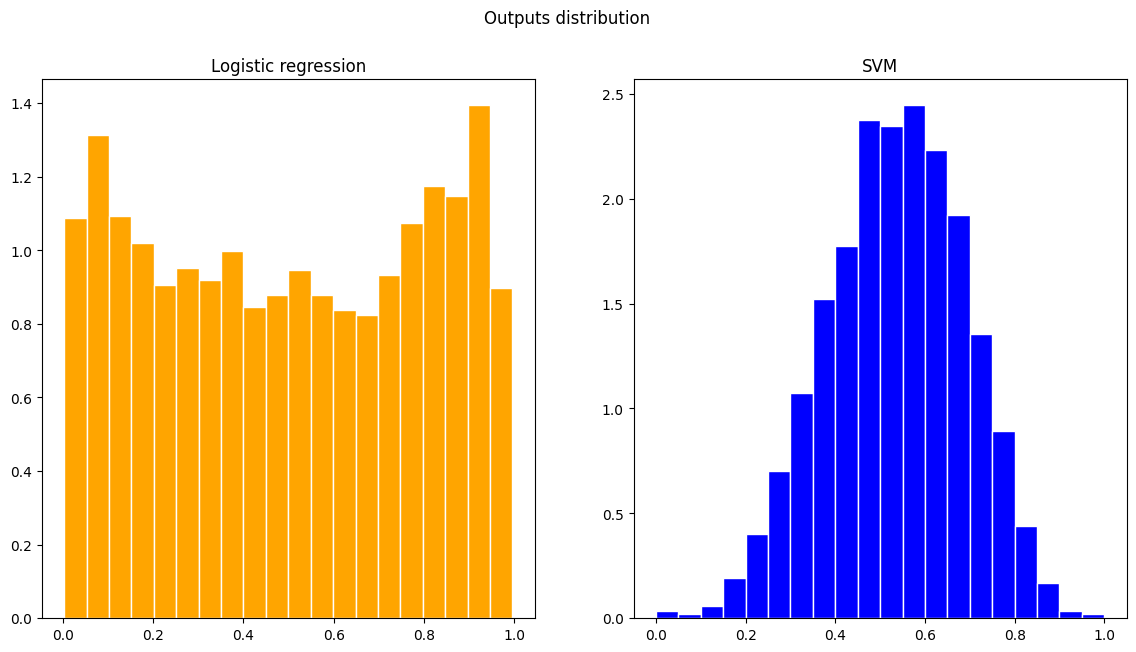

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

axs[0].hist(y_logreg, bins=20, color='orange', density='True', edgecolor='white')
axs[0].set_title('Logistic regression')

axs[1].hist(y_svm, bins=20, color='blue', density='True', edgecolor='white')
axs[1].set_title('SVM')

plt.suptitle('Outputs distribution')
plt.show()

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:**

Логистическая регрессия предсказывает вероятности, поэтому распределение скорее равномерное. Там, где есть заметные глазу провалы (около 0.2, 0.4 и 0.7), даже можно увидеть изломы и отклонения от верного ответа у калибровочной кривой.

SVM распределен нормально, пик приходится где-то между 0.5 и 0.6 и как раз в этом месте калибровочная прямая пересекает идеальный классификатор. А в концах, где модель редко бывает уверена в своем предсказании, очень сильно отходит от идеального классификатора. Так происходит потому, что очень много объектов лежат близко к разделяющей прямой

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

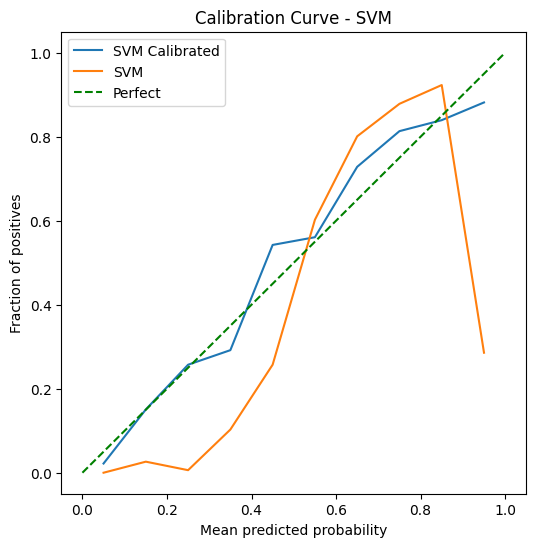

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_svm = CalibratedClassifierCV(model_svm, cv='prefit', method='sigmoid').fit(X_train, y_train)
y_pred = calibrated_svm.predict_proba(X_test)[:,1]

fig, axs = plt.subplots(1, 1, figsize=(6, 6))
plot_calibration_curve(axs, y_test, y_pred, 'SVM Calibrated')
plot_calibration_curve(axs, y_test, y_svm, 'SVM')

axs.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')
axs.set_xlabel('Mean predicted probability')
axs.set_ylabel('Fraction of positives')
axs.set_title('Calibration Curve - SVM')
axs.legend()
plt.tight_layout()
plt.show()

**Вопрос:** Улучшилась ли калибровочная кривая?

**Ответ:** Да, причем заметно

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [ ]:
#your code here

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [ ]:
df = pd.read_csv('bike_buyers.csv')
df.head(3)

,ID,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
0,12496,Married,Female,40000.0,1.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,Europe,42.0,No
1,24107,Married,Male,30000.0,3.0,Partial College,Clerical,Yes,1.0,0-1 Miles,Europe,43.0,No
2,14177,Married,Male,80000.0,5.0,Partial College,Professional,No,2.0,2-5 Miles,Europe,60.0,No


In [ ]:
dtypes_info = df.dtypes.rename('Data Types')
missing_info = df.isnull().sum().rename('Missing Values')
na_df = pd.concat([missing_info, dtypes_info], axis=1)
na_df

,Missing Values,Data Types
ID,0,int64
Marital Status,7,object
Gender,11,object
Income,6,float64
Children,8,float64
Education,0,object
Occupation,0,object
Home Owner,4,object
Cars,9,float64
Commute Distance,0,object


In [ ]:
#Заменим пропуски категориальных переменных
categorical_columns = df.select_dtypes(include='object')
numeric_columns = df.select_dtypes(include='number')
df.update(categorical_columns.fillna(value='undefined'))

In [ ]:
missing_info = df.isnull().sum().rename('Missing Values')
na_df = pd.concat([missing_info, dtypes_info], axis=1)
na_df

,Missing Values,Data Types
ID,0,int64
Marital Status,0,object
Gender,0,object
Income,6,float64
Children,8,float64
Education,0,object
Occupation,0,object
Home Owner,0,object
Cars,9,float64
Commute Distance,0,object


In [ ]:
numeric_columns.columns

Index(['ID', 'Income', 'Children', 'Cars', 'Age'], dtype='object')

In [ ]:
categorical_columns.columns

Index(['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner',
       'Commute Distance', 'Region', 'Purchased Bike'],
      dtype='object')

In [ ]:
X = df.drop(columns=['Purchased Bike'])
y = (df['Purchased Bike'] == 'Yes').astype('int64')

#Разделим на категориальные признаки и числовые
numerical = ['Income', 'Children', 'Cars', 'Age'] # ID вредный признак
categorical = ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region']
X_numerical = X[numerical]
X_categorical = X[categorical]

В начале поработаем только с категориальными признаками

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [ ]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from time import time

oe_transformer = ColumnTransformer(transformers=[
    ('oe_categorical', OrdinalEncoder(), categorical)
])

pipeline = Pipeline([
    ('oe_transformer', oe_transformer),
    ('logreg_classifier', LogisticRegression())
])

start_time = time()
pipeline.fit(X_train, y_train)
training_time = time() - start_time
y_pred = pipeline.predict_proba(X_test)[:,1]

precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR =', auc(recall, precision))
print('Time (ms) = ', training_time * 1000)


AUC-PR = 0.5789437602089755
Time (ms) =  8.45956802368164


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [ ]:
ohe_transformer = ColumnTransformer(transformers=[
    ('ohe_categorical', OneHotEncoder(), categorical)
])

pipeline = Pipeline([
    ('ohe_transformer', ohe_transformer),
    ('logreg_classifier', LogisticRegression())
])

start_time = time()
pipeline.fit(X_train, y_train)
training_time = time() - start_time
y_pred = pipeline.predict_proba(X_test)[:,1]

precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR =', auc(recall, precision))
print('Time (ms) = ', training_time * 1000)

AUC-PR = 0.6618645231989089
Time (ms) =  13.870000839233398


Ура-ура, легким движением руки (и замедлением почти в два раза), сильно улучшился результат

Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class MeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_columns):
        self.categorical_columns = categorical_columns
        self.mean_target_encoders = {}

    @staticmethod
    def count_g_j(x_j, X_j, y):
        return ((X_j == x_j) & (y == 1)).sum() / (X_j == x_j).sum()

    def fit(self, X, y):
        self.X = X.copy()
        self.y = y.copy()
        for column in self.categorical_columns:
            self.mean_target_encoders[column] = {x_j: self.count_g_j(x_j, X[column], y) for x_j in X[column].unique()}
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for column in self.categorical_columns:
            for x_j in X[column].unique():
                X_transformed.loc[(X_transformed[column] == x_j), column] = self.mean_target_encoders[column][x_j]
        return X_transformed


In [ ]:
mte_transformer = ColumnTransformer(transformers=[
    ('mte_categorical', MeanTargetEncoder(categorical), categorical)
])

pipeline = Pipeline([
    ('mte_transformer', mte_transformer),
    ('logreg_classifier', LogisticRegression())
])

start_time = time()
pipeline.fit(X_train, y_train)
training_time = time() - start_time
y_pred = pipeline.predict_proba(X_test)[:,1]

precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR =', auc(recall, precision))
print('Time (ms) = ', training_time * 1000)

AUC-PR = 0.652694015966057
Time (ms) =  35.005807876586914


Ну чего-то как-то долго и немного хуже, чем OHE, но зато своими руками!

![](https://upload.wikimedia.org/wikipedia/commons/thumb/7/7e/%D0%AD%D1%82%D0%BE_%D0%BD%D0%B5%D0%BC%D0%BD%D0%BE%D0%B3%D0%BE%2C_%D0%BD%D0%BE_%D1%8D%D1%82%D0%BE_%D1%87%D0%B5%D1%81%D1%82%D0%BD%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0.jpg/500px-%D0%AD%D1%82%D0%BE_%D0%BD%D0%B5%D0%BC%D0%BD%D0%BE%D0%B3%D0%BE%2C_%D0%BD%D0%BE_%D1%8D%D1%82%D0%BE_%D1%87%D0%B5%D1%81%D1%82%D0%BD%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0.jpg)

##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [ ]:
class EffectiveMeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_columns):
        self.categorical_columns = categorical_columns
        self.mean_target_encoders = {}

    def fit(self, X, y):
        self.X = X.copy()
        self.y = y.copy()
        self.X['target'] = y
        self.mean_target_encoders = {feature: self.X.groupby(feature)['target'].mean() for feature in self.categorical_columns}
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for feature, mean in self.mean_target_encoders.items():
            X_transformed[feature] = X_transformed[feature].map(mean).fillna(self.y.mean())
        return X_transformed


In [ ]:
emte_transformer = ColumnTransformer(transformers=[
    ('emte_categorical', EffectiveMeanTargetEncoder(categorical), categorical)
])

pipeline = Pipeline([
    ('emte_transformer', emte_transformer),
    ('logreg_classifier', LogisticRegression())
])

start_time = time()
pipeline.fit(X_train, y_train)
training_time = time() - start_time
y_pred = pipeline.predict_proba(X_test)[:,1]

precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR =', auc(recall, precision))
print('Time (ms) = ', training_time * 1000)

AUC-PR = 0.652694015966057
Time (ms) =  12.757062911987305


Стало быстрее аж в 3 раза. И вроде бы все правильно, потому что AUC-PR остался таким же

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [ ]:
class NoiseMeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_columns, noise_level=0.01, random_state=42):
        self.categorical_columns = categorical_columns
        self.mean_target_encoders = {}
        self.noise_level = noise_level
        self.random_state = random_state

    def fit(self, X, y):
        self.X = X.copy()
        self.y = y.copy()
        self.X['target'] = y
        np.random.seed(self.random_state)
        for feature in self.categorical_columns:
            mean_target = self.X.groupby(feature)['target'].mean()
            noise = np.random.normal(0, self.noise_level, len(mean_target))
            self.mean_target_encoders[feature] = mean_target + noise
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for feature, mean in self.mean_target_encoders.items():
            X_transformed[feature] = X_transformed[feature].map(mean).fillna(self.y.mean())
        return X_transformed

In [ ]:
nmte_transformer = ColumnTransformer(transformers=[
    ('nmte_categorical', NoiseMeanTargetEncoder(categorical), categorical)
])

pipeline = Pipeline([
    ('nmte_transformer', nmte_transformer),
    ('logreg_classifier', LogisticRegression())
])

start_time = time()
pipeline.fit(X_train, y_train)
training_time = time() - start_time
y_pred = pipeline.predict_proba(X_test)[:,1]

precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR =', auc(recall, precision))
print('Time (ms) = ', training_time * 1000)

AUC-PR = 0.6618528498160249
Time (ms) =  13.617277145385742


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** Стало лучше, но мне кажется, что тут дело все-таки в том, как я зафиксировала seed. Потому что все-таки это дело очень скользкое и мне повезло

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [ ]:
from sklearn.model_selection import KFold

class CV_NoiseMeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_columns, n_folds=5, noise_level=0.01, random_state=42, cv_random_state=42):
        self.categorical_columns = categorical_columns
        self.mean_target_encoders = {}
        self.noise_level = noise_level
        self.random_state = random_state
        self.n_folds = n_folds
        self.cv_random_state = cv_random_state

    def fit(self, X, y):
        self.X = X.copy()
        self.y = y.copy()
        self.X['target'] = self.y

        kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=self.cv_random_state)
        np.random.seed(self.random_state)

        for train_index, val_index in kf.split(self.X):
            X_train, X_val = self.X.iloc[train_index], self.X.iloc[val_index]
            y_train, y_val = self.y.iloc[train_index], self.y.iloc[val_index]

            for feature in self.categorical_columns:
                mean_target = X_train.groupby(feature)['target'].mean()
                noise = np.random.normal(0, self.noise_level, len(mean_target))
                mean_target += noise
                if feature not in self.mean_target_encoders:
                    self.mean_target_encoders[feature] = []
                self.mean_target_encoders[feature].append(mean_target)

        for feature, mean in self.mean_target_encoders.items():
            self.mean_target_encoders[feature] = pd.concat(mean).groupby(level=0).mean()
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for feature, mean in self.mean_target_encoders.items():
            X_transformed[feature] = X_transformed[feature].map(mean).fillna(self.y.mean())
        return X_transformed

In [ ]:
cv_nmte_transformer = ColumnTransformer(transformers=[
    ('cv_nmte_categorical', CV_NoiseMeanTargetEncoder(categorical, cv_random_state=71), categorical)
])

pipeline = Pipeline([
    ('cv_nmte_transformer', cv_nmte_transformer),
    ('logreg_classifier', LogisticRegression())
])

start_time = time()
pipeline.fit(X_train, y_train)
training_time = time() - start_time
y_pred = pipeline.predict_proba(X_test)[:,1]

precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR =', auc(recall, precision))
print('Time (ms) = ', training_time * 1000)

AUC-PR = 0.6627198119060754
Time (ms) =  25.190353393554688


Ну как-то вроде и стало лучше (для зафиксированного шума как в прошлом задании, что я сделала для наглядности), но опять таки подбор random_state штука страшная

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [ ]:
class SmoothedMeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_columns, c=10):
        self.categorical_columns = categorical_columns
        self.mean_target_encoders = {}
        self.c = c

    def fit(self, X, y):
        self.X = X.copy()
        self.y = y.copy()
        self.X['target'] = self.y
        self.global_mean = self.y.mean()
        for feature in self.categorical_columns:
            smoothed_mean = (self.X.groupby(feature)['target'].sum() + self.c * self.global_mean) / (self.X.shape[0] + self.c)
            unique_cnt = self.X[feature].value_counts().index
            self.mean_target_encoders[feature] = dict(zip(unique_cnt, smoothed_mean))
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for feature, mean in self.mean_target_encoders.items():
            X_transformed[feature] = X_transformed[feature].map(mean).fillna(self.global_mean)
        return X_transformed


In [ ]:
best_auc_pr = 0
best_c = 0
best_time = 0

for c in range (1, 100):
    smte_transformer = ColumnTransformer(transformers=[
        ('smte_categorical', SmoothedMeanTargetEncoder(categorical, c), categorical)
    ])

    pipeline = Pipeline([
        ('smte_transformer', smte_transformer),
        ('logreg_classifier', LogisticRegression())
    ])

    start_time = time()
    pipeline.fit(X_train, y_train)
    training_time = time() - start_time
    y_pred = pipeline.predict_proba(X_test)[:,1]

    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    maxim = max(best_auc_pr,auc(recall, precision))
    if maxim != best_auc_pr:
        best_auc_pr = maxim
        best_c = c
        best_time = training_time * 1000

print('Best AUC-PR =', best_auc_pr)
print('Best C =', best_c)
print('Time (ms) =', best_time)

Best AUC-PR = 0.6842667403379682
Best C = 12
Time (ms) =  4.974126815795898


Для OHE было AUC-PR = 0.652694015966057, Time (ms) =  35.005807876586914. Улучшилось очень сильно, так еще и время обучения модели гораздо меньше

#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к признакам-счетчикам.


В данных есть пропуски - замените их средним значением признака



In [ ]:
meow = X_numerical.isna().sum().to_frame().reset_index()
meow.columns = ['Column', 'None Counts']
meow

,Column,None Counts
0,Income,6
1,Children,8
2,Cars,9
3,Age,8


In [ ]:
X_numerical = X_numerical.fillna(X_numerical.mean())

 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков (вместе и по отдельности). Стало ли лучше?

In [ ]:
meow = X_numerical.nunique().to_frame().reset_index()
meow.columns = ['Column', 'Unique Counts']
meow

,Column,Unique Counts
0,Income,17
1,Children,7
2,Cars,6
3,Age,54


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_numerical, y, test_size=0.25, random_state=777, stratify=y)

In [ ]:
def smooth_mte(X_train, X_test, categorical, c):
    smte_transformer = ColumnTransformer([('smte_categorical', SmoothedMeanTargetEncoder(categorical, c), categorical)])
    pipeline = Pipeline([('smte_transformer', smte_transformer),
        ('logreg_classifier', LogisticRegression())])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict_proba(X_test)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    return auc(recall, precision)

In [ ]:
print('Encoding ' + ', '.join(X_train.columns))
best_auc_pr = 0
best_c = 0
for c in range(1, 100):
    current_auc_pr = smooth_mte(X_train, X_test, X_train.columns, c)
    if current_auc_pr > best_auc_pr:
        best_auc_pr = current_auc_pr
        best_c = c
print('Best AUC-PR =', best_auc_pr)
print('Best C =', best_c)
print()


Encoding Income, Children, Cars, Age
Best AUC-PR = 0.55602763712911
Best C = 93



In [ ]:
for i in range(0, X_train.columns.shape[0]):
    print('Encoding ' + X_train.columns[i])
    best_auc_pr = 0
    best_c = 0
    for c in range(1, 100):
        current_auc_pr = smooth_mte(X_train, X_test, [X_train.columns[i]], c)
        if current_auc_pr > best_auc_pr:
            best_auc_pr = current_auc_pr
            best_c = c
    print('Best AUC-PR =', best_auc_pr)
    print('Best C =', best_c)
    print()


Encoding Income
Best AUC-PR = 0.5193073693548121
Best C = 1

Encoding Children
Best AUC-PR = 0.5554884195575082
Best C = 1

Encoding Cars
Best AUC-PR = 0.6043472006048902
Best C = 1

Encoding Age
Best AUC-PR = 0.47013383113293333
Best C = 1



Можно сделать вывод, что чем больше уникальных значений принимает признак, тем AUC-PR для такого кодирования, даже если подбирать гиперпараметры

> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__

Плюсы:
* Не так много памяти нужно (не раздувается количество признаков)
* Потенциально лучше качество
* Хорошо работает с редкими категориями

Минусы:
* Долго и больно подбирать гиперпараметры, чтобы качество не было хуже, чем OHE
* В зависимости от реализации работает дольше (или быстрее, опять же, зависит от подхода)


# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2023-11-21 23:34:00--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Распознаётся archive.ics.uci.edu (archive.ics.uci.edu)… 128.195.10.252
Подключение к archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: нет данных
Сохранение в: «adult.data.1»

adult.data.1            [          <=>       ]   3,79M  1,53MB/s    за 2,5s    

2023-11-21 23:34:04 (1,53 MB/s) - «adult.data.1» сохранён [3974305]



In [ ]:
columns = ['age', 'workclass', 'fnlwgt', 'education',
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
17259,57,Self-emp-inc,123053,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,15024,0,50,India,1


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`.

In [ ]:
X = df.drop(columns=['income'])
y = df['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [ ]:
categorical_columns = df.select_dtypes(include='object')
df.update(categorical_columns.fillna(value='undefined'))
numeric_columns = df.select_dtypes(include='number')
numeric_columns = numeric_columns.drop('income', axis=1)

In [ ]:
categorical = list(categorical_columns.columns)
categorical

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country']

In [ ]:
numerical = list(numeric_columns.columns)
numerical

['age',
 'fnlwgt',
 'education-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week']

In [ ]:
encoder = OneHotEncoder()
print('Изначальное количество категориальных:', X_train.shape[1])
print('Количество категориальных после OHE: ', encoder.fit_transform(X_train[categorical]).shape[1])

Изначальное количество категориальных: 14
Количество категориальных после OHE:  102


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [ ]:
ohe_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical)
])

pipeline = Pipeline(steps=[
    ('ohe', ohe_transformer),
    ('logreg_classifier', LogisticRegression(max_iter=500))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
ohe_auc_pr = auc(recall, precision)
print('AUC-PR =', ohe_auc_pr)

AUC-PR = 0.686024268189623


#### __Задание 9. Встроенные методы (0.5 балла)__

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [ ]:
np.sort(np.abs(pipeline.named_steps['logreg_classifier'].coef_[0])).shape[0]

102

In [ ]:
from sklearn.feature_selection import SelectFromModel

start_time = time()

threshold = np.sort(np.abs(pipeline.named_steps['logreg_classifier'].coef_[0]))[-40]
selector = SelectFromModel(pipeline.named_steps['logreg_classifier'], threshold=threshold).fit(ohe_transformer.transform(X_train), y_train)

selecting = time() - start_time

pipeline = Pipeline([
    ('ohe', ohe_transformer),
    ('selector', selector),
    ('logreg_classifier', LogisticRegression(max_iter=500))
])
features_time = time() - start_time

model = pipeline.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
training_time = time() - start_time

precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR =', auc(recall, precision))
print('Selecting features (ms) =', features_time * 1000)
print('Time (ms) =', training_time * 1000)


AUC-PR = 0.668757498872438
Selecting features (ms) = 245.44286727905273
Time (ms) = 639.7168636322021


In [ ]:
selected_feature_names = ohe_transformer.named_transformers_['ohe'].get_feature_names_out(categorical)[selector.get_support()]
print('Selected Features:')
print(selected_feature_names)

Selected Features:
['workclass_ Federal-gov' 'workclass_ Self-emp-inc'
 'workclass_ Without-pay' 'education_ 10th' 'education_ 11th'
 'education_ 1st-4th' 'education_ 5th-6th' 'education_ 7th-8th'
 'education_ 9th' 'education_ Bachelors' 'education_ Doctorate'
 'education_ Masters' 'education_ Preschool' 'education_ Prof-school'
 'marital-status_ Married-AF-spouse' 'marital-status_ Married-civ-spouse'
 'marital-status_ Married-spouse-absent' 'marital-status_ Never-married'
 'marital-status_ Separated' 'occupation_ Exec-managerial'
 'occupation_ Farming-fishing' 'occupation_ Other-service'
 'occupation_ Priv-house-serv' 'occupation_ Prof-specialty'
 'occupation_ Protective-serv' 'occupation_ Tech-support'
 'relationship_ Own-child' 'relationship_ Wife' 'native-country_ Cambodia'
 'native-country_ Canada' 'native-country_ Columbia'
 'native-country_ Dominican-Republic' 'native-country_ England'
 'native-country_ France' 'native-country_ Germany' 'native-country_ Hong'
 'native-country_ I

Изменилось ли качество? Как?

**Ответ:** Стало сильно хуже, AUC-PR уменьшился на 0.02. Мы оставили только 40 из 102 признаков, что больше половины, так что в целом объяснимо, почему так

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [ ]:
ohe_scaling_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numerical)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', ohe_scaling_transformer),
    ('logreg_classifier', LogisticRegression(max_iter=500))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
ohe_scaling_auc_pr = auc(recall, precision)
print('AUC-PR =', ohe_scaling_auc_pr)

AUC-PR = 0.767127849380956


Качество ну очень сильно возросло, аж на 0.1. Вывод – нормирование хорошо

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [ ]:
transformer = ColumnTransformer(
    transformers=[
        ('categorical', Pipeline([
            ('ohe', OneHotEncoder(sparse_output=False)),
            ('scaler', StandardScaler())
        ]), categorical),
        ('numerical', StandardScaler(), numerical)
    ])
X_train_scaled = pd.DataFrame(transformer.fit_transform(X_train), columns=list(transformer.get_feature_names_out()))
X_test_scaled = pd.DataFrame(transformer.transform(X_test), columns=list(transformer.get_feature_names_out()))

model = LogisticRegression(max_iter=500)
model.fit(X_train_scaled, y_train)

threshold = np.sort(np.abs(model.coef_[0]))[-40]
selector = SelectFromModel(model, threshold=threshold).fit(X_train_scaled, y_train)

pipeline = Pipeline([
    ('selector', selector),
    ('logreg_classifier', LogisticRegression(max_iter=500))
])
model = pipeline.fit(X_train_scaled, y_train)
y_pred = model.predict_proba(X_test_scaled)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR =', auc(recall, precision))

AUC-PR = 0.761089616940183


In [ ]:
new_selected_features = np.array(list(transformer.get_feature_names_out()))[selector.get_support()]
print('Selected Features:')
print(new_selected_features)


Selected Features:
['categorical__workclass_ Federal-gov'
 'categorical__workclass_ Self-emp-not-inc'
 'categorical__workclass_ Without-pay' 'categorical__education_ 10th'
 'categorical__education_ 11th' 'categorical__education_ 7th-8th'
 'categorical__education_ Bachelors' 'categorical__education_ Doctorate'
 'categorical__education_ Masters' 'categorical__education_ Preschool'
 'categorical__education_ Prof-school'
 'categorical__marital-status_ Divorced'
 'categorical__marital-status_ Married-civ-spouse'
 'categorical__marital-status_ Married-spouse-absent'
 'categorical__marital-status_ Never-married'
 'categorical__marital-status_ Separated'
 'categorical__marital-status_ Widowed'
 'categorical__occupation_ Exec-managerial'
 'categorical__occupation_ Farming-fishing'
 'categorical__occupation_ Handlers-cleaners'
 'categorical__occupation_ Other-service'
 'categorical__occupation_ Priv-house-serv'
 'categorical__occupation_ Prof-specialty'
 'categorical__occupation_ Protective-serv

Результат поднялся почти до обычного OHE + Scaling, но намного лучше, чем для обычного OHE с отбором 40 признаков. Списки отличаются (насколько сильно сказать не могу, но я не присматриваясь вижу как минимум 4 различия)

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.



In [ ]:
start = time()
X_train_transformed = ohe_scaling_transformer.fit_transform(X_train, y_train)
X_test_transformed = ohe_scaling_transformer.transform(X_test)

def count_t_j(X, y):
    mu_pos = np.mean(X[y == 1], axis=0)
    mu_neg =  np.mean(X[y == 0], axis=0)
    sigma_pos = np.var(X[y == 0], axis=0)
    sigma_neg = np.var(X[y == 0], axis=0)
    n_pos = X[y == 1].shape[0]
    n_neg = X[y == 0].shape[0]

    return np.abs(mu_pos - mu_neg) / np.sqrt((n_pos * sigma_pos + n_neg * sigma_neg) / (n_pos + n_neg))

t_statistics = np.array(count_t_j(X_train_transformed.todense(), y_train)).flatten()
threshold = np.sort(t_statistics)[-40]
X_train_transformed = X_train_transformed[:, t_statistics >= threshold]
X_test_transformed = X_test_transformed[:, t_statistics >= threshold]
features_time = time() - start

model = LogisticRegression(max_iter=500).fit(X_train_transformed, y_train)
y_pred = model.predict_proba(X_test_transformed)[:,1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR =', auc(recall, precision))
print('Selecting features (ms) =', features_time * 1000)


AUC-PR = 0.7619835631874088
Selecting features (ms) = 93.55711936950684


Правда в разы быстрее! Так еще и хороший результат

#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, на каждом шаге мы будем удалять такой признак $j$, что качество модели на множестве оставшихся признаков без $j$ максимально, то есть удалять мы будем наиболее бесполезный признак.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

In [ ]:
encoder = OneHotEncoder(sparse_output=False)
scaler = StandardScaler()
X_train_transformed = pd.DataFrame(scaler.fit_transform(encoder.fit_transform(X_train[categorical])), columns=encoder.get_feature_names_out(input_features=categorical))
X_test_transformed = pd.DataFrame(scaler.transform(encoder.transform(X_test[categorical])), columns=encoder.get_feature_names_out(input_features=categorical))

X_train_transformed, X_val_transformed, y_train, y_val = train_test_split(X_train_transformed, y_train, test_size=0.25, random_state=777, stratify=y_train)
X_train_transformed, X_val_transformed = X_train_transformed.reset_index().drop(columns='index'), X_val_transformed.reset_index().drop(columns='index')

In [ ]:
X_train_copy, X_val_copy = X_train_transformed.copy(), X_val_transformed.copy()

for i in range(X_train_transformed.shape[1] - 40):
    best_auc_pr = 0
    dropped_feature = None

    for feature in X_train_copy.columns:
        model = LogisticRegression(max_iter=500).fit(X_train_copy.drop(columns=feature), y_train)
        y_pred = model.predict_proba(X_val_copy.drop(columns=feature))[:, 1]
        precision, recall, _ = precision_recall_curve(y_val, y_pred)
        auc_pr = auc(recall, precision)

        if auc_pr > best_auc_pr:
            best_auc_pr = auc_pr
            dropped_feature = feature

    if dropped_feature is not None:
        X_train_copy = X_train_copy.drop(columns=dropped_feature)
        X_val_copy = X_val_copy.drop(columns=dropped_feature)

print('Количество оставшихся признаков: ', X_train_copy.shape[1])


Количество оставшихся признаков:  40


In [ ]:
model = LogisticRegression(max_iter=500).fit(X_train_copy, y_train)
y_pred = model.predict_proba(X_test_transformed[X_train_copy.columns])[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print("AUC-PR =", auc(recall, precision))

AUC-PR = 0.6835842088612096


Оно считалось 22 минуты, а качество сильно упало. Стоит сделать выводы. Алгоритм работает за квадрат, нам просто повезло, что признаков не так много, чтобы он свалился совсем

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [ ]:
X_train_copy_adding, X_val_copy_adding = X_train_transformed.copy(), X_val_transformed.copy()

added_features_count = 0

while added_features_count < 40:
    best_auc_pr = 0
    added_feature = None

    for feature in X_train_transformed.columns:
        if feature not in X_train_copy_adding.columns:
            model = LogisticRegression(max_iter=500).fit(X_train_copy_adding.assign(**{feature: X_train_transformed[feature]}), y_train)
            y_pred = model.predict_proba(X_val_copy_adding.assign(**{feature: X_val_transformed[feature]}))[:, 1]
            precision, recall, _ = precision_recall_curve(y_val, y_pred)
            auc_pr = auc(recall, precision)

            if auc_pr > best_auc_pr:
                best_auc_pr = auc_pr
                added_feature = feature

    if added_feature is not None:
        X_train_copy = X_train_copy_adding.assign(**{added_feature: X_train_transformed[added_feature]})
        X_val_copy = X_val_copy_adding.assign(**{added_feature: X_val_transformed[added_feature]})
        added_features_count += 1

print('Количество добавленных признаков: ', X_train_copy.shape[1])

In [ ]:
model = LogisticRegression(max_iter=500).fit(X_train_copy_adding, y_train)
y_pred = model.predict_proba(X_test_copy_adding[X_train_copy_adding.columns])[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print("AUC-PR =", auc(recall, precision))

Я отрубила после того, как оно работало целый час. Честно считаю, что если не досчиталось за столько времени, то лучше и не трогать

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:**

* Встроенные методы (конкретно оставление топ-n самых влияющих признаков) не самая лучшая идея, потому что могут быть нелинейные зависимости, которые мы не учли при выбрасывании. Ну и вообще поведение в таком случае может оказаться непредсказуемым

* Методы фильтрации работают довольно быстро и дают хорошее качество (лучше, чем выбрасывание самых весомых признаков)

* Методы-обертки (жадники) это вычислительный ужас, потому что они работают за квадрат, во много миллионов раз медленнее

Я лично считаю, что оптимальней из них всех использовать метод фильтрации с t-статистикой

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

In [ ]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [ ]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=500)

Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

In [ ]:
categorical_columns = df.select_dtypes(include='object')
numeric_columns = df.select_dtypes(include='number')
categorical_columns = categorical_columns.drop('y', axis=1)
numeric_columns = numeric_columns.drop('duration', axis=1)

In [ ]:
categorical = list(categorical_columns.columns)
categorical

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

In [ ]:
numerical = list(numeric_columns.columns)
numerical

['age',
 'campaign',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']

In [ ]:
ohe_scaling_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numerical)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', ohe_scaling_transformer),
    ('regression', LogisticRegression(max_iter=500))
])

idx = 1
for train_index, val_index in kf.split(X):
    X_train, X_val = X.loc[train_index], X.loc[val_index]
    y_train, y_val = y.loc[train_index], y.loc[val_index]
    model = pipeline.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:, 1]
    precision, recall, _ = precision_recall_curve(y_val, y_pred)
    print('Fold ', idx, 'AUC-PR =', auc(recall, precision))
    idx += 1


Fold  1 AUC-PR = 0.480157650130818
Fold  2 AUC-PR = 0.43776066608141906
Fold  3 AUC-PR = 0.45006392523542876
Fold  4 AUC-PR = 0.4603221669433627
Fold  5 AUC-PR = 0.4308644493539369


Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [ ]:
income, calls = [], []

for train_index, val_index in kf.split(X):
    X_train, X_val = X.loc[train_index], X.loc[val_index]
    y_train, y_val = y.loc[train_index], y.loc[val_index]
    model = pipeline.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    income.append((y_val & y_pred).sum() * 10)
    calls.append(y_pred.sum())

print('Средний заработок = ', np.mean(income))
print('Стадартное отклонение заработка = ', np.std(income))
print('Средняя сумма выплат операторам = ', np.mean(calls))
print('Стадартное отклонение выплат = ', np.std(calls))


Средний заработок =  2130.0
Стадартное отклонение заработка =  107.144761887831
Средняя сумма выплат операторам =  324.2
Стадартное отклонение выплат =  7.909487973314076


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [ ]:
income, calls = [], []

for train_index, val_index in kf.split(X):
    X_train, X_val = X.loc[train_index], X.loc[val_index]
    y_train, y_val = y.loc[train_index], y.loc[val_index]
    model = pipeline.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    income.append((y_val & y_pred).sum() * np.random.uniform(0, 20))
    calls.append(y_pred.sum())

print('Средний заработок = ', np.mean(income))
print('Стадартное отклонение заработка = ', np.std(income))
print('Средняя сумма выплат операторам = ', np.mean(calls))
print('Стадартное отклонение выплат = ', np.std(calls))


Средний заработок =  1289.1514870587534
Стадартное отклонение заработка =  879.4261922079644
Средняя сумма выплат операторам =  324.2
Стадартное отклонение выплат =  7.909487973314076


Чувствую себя так, будто это у меня деньги украли. Ну в общем, выросла дисперсия, упало среднее значение. А дисперсия = непредсказуемость. Хотя несколько раз я эту ячейку смогла вывести и на сильный выигрыш (чистый рандом)

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

In [ ]:
encoder = OneHotEncoder(sparse_output=False)
scaler = StandardScaler()
X_transformed = pd.DataFrame(scaler.fit_transform(encoder.fit_transform(X[categorical])), columns=encoder.get_feature_names_out(input_features=categorical))
X_transformed[numerical] = scaler.fit_transform(X[numerical])

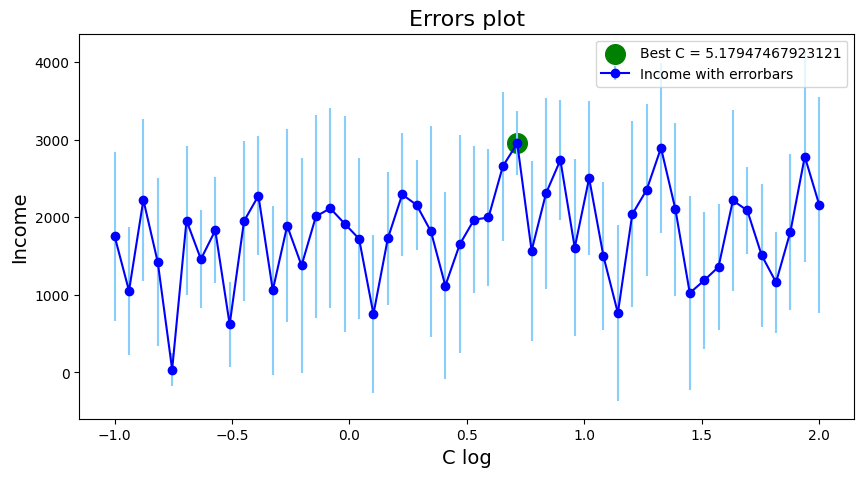

Наибольшая прибыль =  2952.3470916156302
Best C =  5.17947467923121


In [ ]:
def errorbar():
    income, var_income = [], []
    max_income = 0
    best_c = 0
    grid_param = np.logspace(-1, 2, 50)

    for c in grid_param:
        income_for_c = []
        for train_index, val_index in kf.split(X_transformed):
            X_train, X_val = X_transformed.loc[train_index], X_transformed.loc[val_index]
            y_train, y_val = y.loc[train_index], y.loc[val_index]
            model = LogisticRegression(C=c, max_iter=500).fit(X_train, y_train)
            y_pred = model.predict(X_val)
            income_for_c.append((y_val & y_pred).sum() * np.random.uniform(0, 20) - y_pred.sum())
        income.append(np.mean(income_for_c))
        if max_income < np.mean(income_for_c):
            max_income = np.mean(income_for_c)
            best_c = c
        var_income.append(np.std(income_for_c))

    plt.figure(figsize=(10, 5))
    plt.errorbar(np.log10(grid_param), income, var_income, fmt='o-', label='Income with errorbars', ecolor='lightskyblue', color='blue')
    plt.scatter(np.log10(best_c), max_income, color='g', marker='o', s=200, label=f'Best C = {best_c}')
    plt.title('Errors plot', fontsize=16)
    plt.xlabel('C log', fontsize=14)
    plt.ylabel('Income', fontsize=14)
    plt.legend()
    plt.show()

    return max_income, best_c

max_income, best_c = errorbar()
print('Наибольшая прибыль = ', max_income)
print('Best C = ', best_c)

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

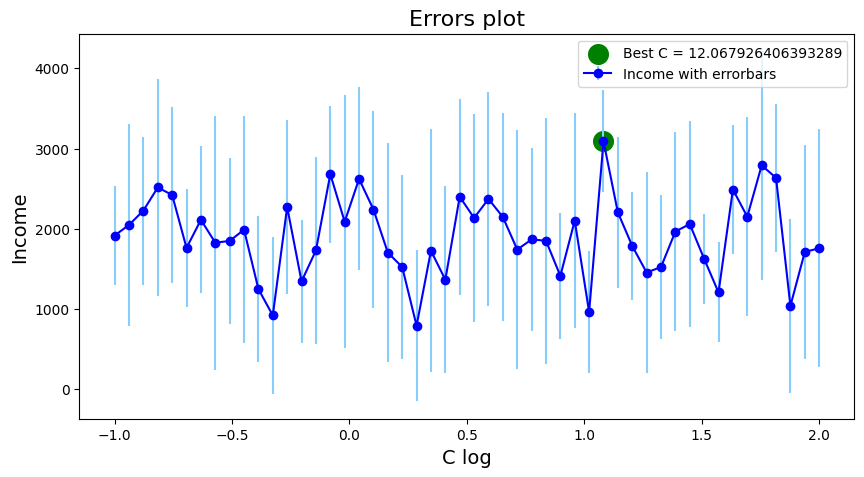

Наибольшая прибыль =  3090.592223130362
Best C =  12.067926406393289


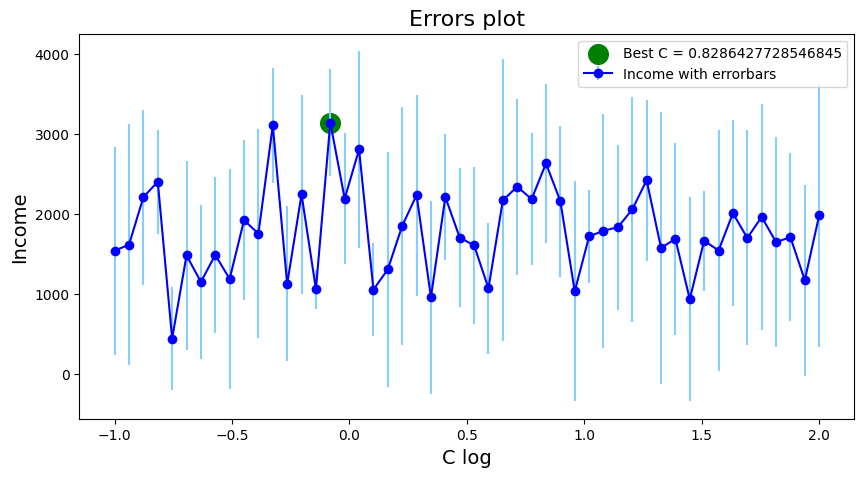

Наибольшая прибыль =  3146.7853232783077
Best C =  0.8286427728546845


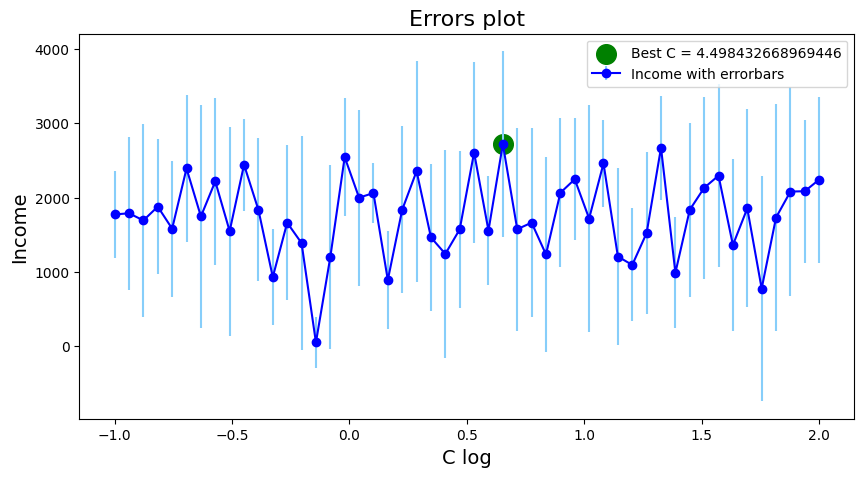

Наибольшая прибыль =  2719.9061039461862
Best C =  4.498432668969446


In [ ]:
for i in range(3):
    max_income, best_c = errorbar()
    print('Наибольшая прибыль = ', max_income)
    print('Best C = ', best_c)

Каждый раз получается разное. Закономерности нет, как минимум потому, что мы не фиксировали random_seed при подсчете выручки

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ Нам важнее revall, потому что мы хотим максимизировать число положительных ответов, а звонки стоят недорого. Поэтому нам не страшно позвонить лишний раз не туда



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

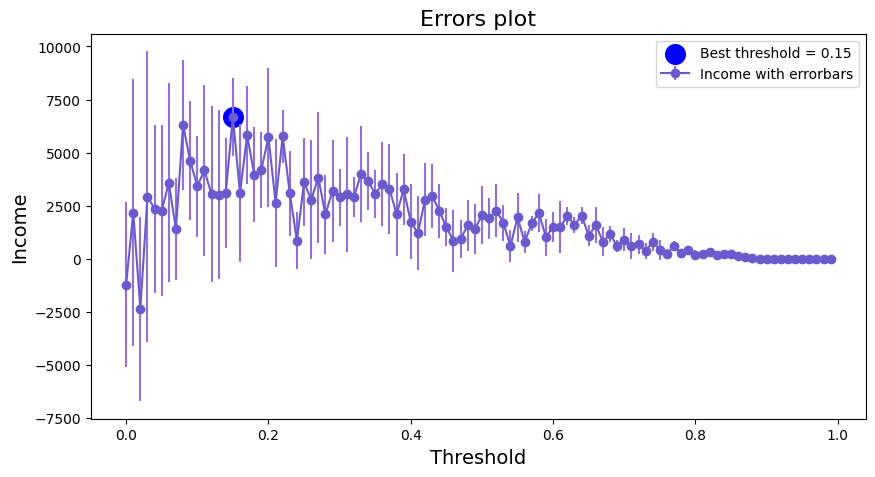

Наибольшая прибыль =  6696.771203743358
Best threshold =  0.15


In [ ]:
def threshold_errorbar():
    income, var_income = [], []
    max_income = 0
    best_threshold = 0
    grid_param = np.arange(0, 1, 0.01)

    for threshold in grid_param:
        income_for_threshold = []
        for train_index, val_index in kf.split(X_transformed):
            X_train, X_val = X_transformed.loc[train_index], X_transformed.loc[val_index]
            y_train, y_val = y.loc[train_index], y.loc[val_index]
            model = LogisticRegression(max_iter=500).fit(X_train, y_train)
            y_pred = model.predict_proba(X_val)[:, 1] > threshold
            income_for_threshold.append((y_val & y_pred).sum() * np.random.uniform(0, 20) - y_pred.sum())
        income.append(np.mean(income_for_threshold))
        if max_income < np.mean(income_for_threshold):
            max_income = np.mean(income_for_threshold)
            best_threshold = threshold
        var_income.append(np.std(income_for_threshold))

    plt.figure(figsize=(10, 5))
    plt.errorbar(grid_param, income, var_income, fmt='o-', label='Income with errorbars', ecolor='mediumpurple', color='slateblue')
    plt.scatter(best_threshold, max_income, color='b', marker='o', s=200, label=f'Best threshold = {best_threshold}')
    plt.title('Errors plot', fontsize=16)
    plt.xlabel('Threshold', fontsize=14)
    plt.ylabel('Income', fontsize=14)
    plt.legend()
    plt.show()

    return max_income, best_threshold

max_income, best_threshold = threshold_errorbar()
print('Наибольшая прибыль = ', max_income)
print('Best threshold = ', best_threshold)

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог.




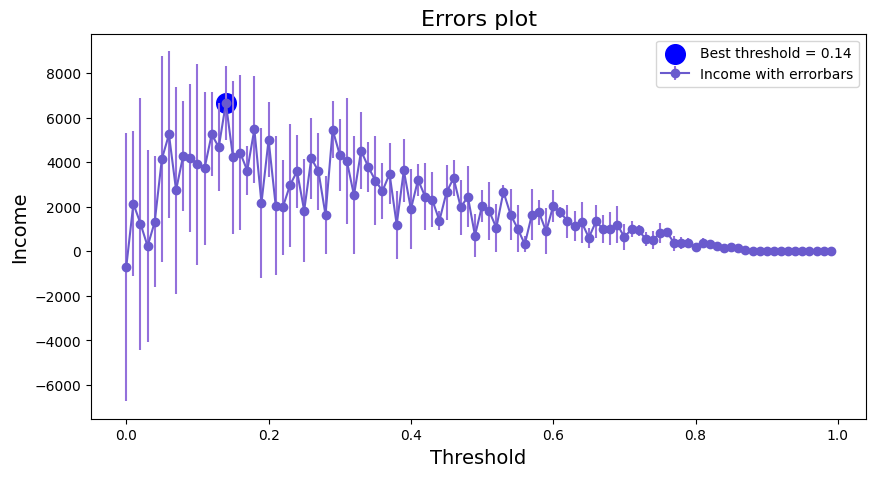

Наибольшая прибыль =  6658.631833040434
Best threshold =  0.14


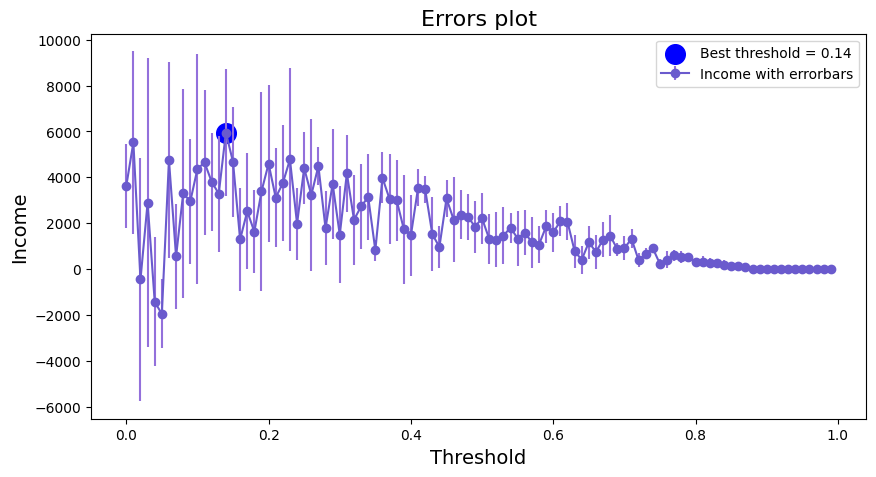

Наибольшая прибыль =  5956.251026454258
Best threshold =  0.14


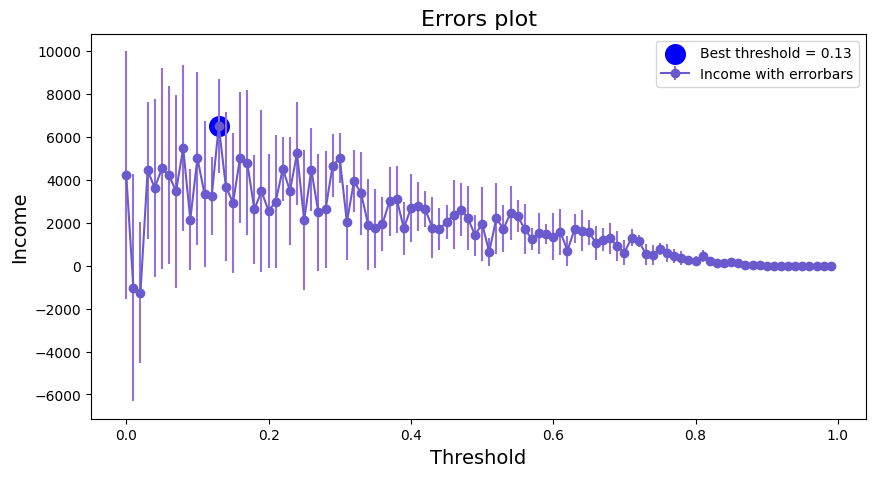

Наибольшая прибыль =  6515.681150007077
Best threshold =  0.13


In [ ]:
for i in range(3):
    max_income, best_threshold = threshold_errorbar()
    print('Наибольшая прибыль = ', max_income)
    print('Best threshold = ', best_threshold)

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__

Самое выгодное для нас значение порога попадает рядом с 0.15.

Думаем, почему так:

* При очень совсем значении порога мы обзваниваем вообще каждого первого клиента. Среди них точно не все согласны платить, а на звонки мы тратим деньги, поэтому мы играем себе в убыток

* При высоком значении порога мы звоним меньшему числу клиентов, поэтому тратим на звонки не так много. Но далеко не все они готовы давать нам деньги, поэтому мы в итоге сходимся к 0

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [ ]:
from sklearn.metrics import recall_score, precision_score

precision, recall = [], []
best_threshold = 0.15

for train_index, val_index in kf.split(X_transformed):
    X_train, X_val = X_transformed.loc[train_index], X_transformed.loc[val_index]
    y_train, y_val = y.loc[train_index], y.loc[val_index]
    model = LogisticRegression(max_iter=500).fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:, 1] > best_threshold
    precision.append(precision_score(y_val, y_pred))
    recall.append(recall_score(y_val, y_pred))

print('Среднее значение precision = ', np.mean(precision))
print('Стандартное отклонение precision = ', np.std(precision))
print()
print('Среднее значение recall = ', np.mean(recall))
print('Стандартное отклонение recall = ', np.std(recall))

Среднее значение precision =  0.3902437531112085
Стандартное отклонение precision =  0.01469410952035974

Среднее значение recall =  0.6008616988304334
Стандартное отклонение recall =  0.02021977772193154


Можно пронаблюдать, что наша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом:
- выберите только те пороги, на которых достигается необходимый recall,
- затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат,
- посчитайте площадь под отсеченной кривой

AUC-PR =  0.44945998836230805


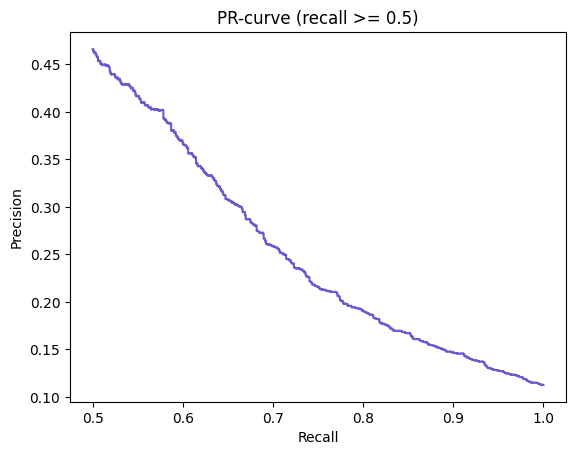

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.25, random_state=777, stratify=y)
model = LogisticRegression(max_iter=500).fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

print('AUC-PR = ', auc(recall, precision))

plt.plot(recall[recall >= 0.5], precision[recall >= 0.5], color='slateblue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR-curve (recall >= 0.5)')
plt.show()


__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ Просроченный на 1 день онигири с угрем из азбуки вкуса, кусок торта (недавно был день рождения у мамы), чай с бабушкиным вареньем. Вот

![](https://cs12.pikabu.ru/post_img/2022/11/19/8/1668865550144926632.jpg)